## 0. Importing PyTorch and setting up device-agnostic code

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:",{device})
print()

if device.type =="cuda":
  print(torch.cuda.get_device_name(0))

Using device: {device(type='cuda')}

Tesla T4


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Training on GPU...Ready for HyperJumo...")
else:
    device = torch.device("cpu")
    print("Training on CPU...May the force be with you...")


Training on GPU...Ready for HyperJumo...


## 1. Get Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
from pathlib import Path

zip_path="/content/drive/MyDrive/Colab Notebooks/datathon-ai-qualification-round.zip"

image_path = Path("/content/datathon")

with zipfile.ZipFile(zip_path ,"r") as zip_ref:
    zip_ref.extractall(image_path)

print(f"The zip file is extracted to the '{image_path}' directory.")


The zip file is extracted to the '/content/datathon' directory.


In [ ]:
import os
import pandas as pd
from PIL import Image
import torchvision.transforms.functional as F
from torchvision.io import read_image
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, target_transform=None):
        # Read the CSV file containing image file names and class labels
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.img_labels = self.img_labels.dropna(subset=['city'])
        self.img_labels = self.img_labels.reset_index(drop=True)

        # Drop rows where the 'city' column is NaN (if any)
        self.img_labels = self.img_labels.dropna(subset=['city'])

        # Infer class names from the 'city' column and create a mapping to indices
        self.classes = sorted(self.img_labels['city'].unique())
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Get the image filename from the 'filename' column
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)  # PyTorch tensor
        image = F.to_pil_image(image)  # Convert tensor to PIL Image

        # Get the label from the 'city' column
        label_name = self.img_labels.iloc[idx, 1]
        label = self.class_to_idx[label_name]

        # Apply transformations to the image (if provided)
        if self.transform:
            image = self.transform(image)  # Apply transformations to PIL image
        if self.target_transform:
            label = self.target_transform(label)

        return image, label


In [ ]:
train_dir = image_path /"train/train"
test_dir = image_path / "test/test"
train_dir,test_dir

(PosixPath('/content/datathon/train/train'),
 PosixPath('/content/datathon/test/test'))

In [ ]:
import os
import pathlib
import torch
from PIL import Image
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
target_directory = train_dir
print(f"Target directory: {target_directory}")

class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: /content/datathon/train/train
Class names found: ['train']


In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
      raise FileNotFoundError(f"Couldn't find any classes in {directory} ... Please check file structure")

    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [ ]:
for root, dirs, files in os.walk(image_path):
    print(f"Directory: {root}")
    print(f"Subdirectories: {dirs}")
    print(f"Files: {files[:5]}")
    print("-" * 40)

Directory: /content/datathon
Subdirectories: ['train', 'test']
Files: ['train_data.csv', 'test.csv']
----------------------------------------
Directory: /content/datathon/train
Subdirectories: ['train']
Files: []
----------------------------------------
Directory: /content/datathon/train/train
Subdirectories: []
Files: ['image_14483.jpg', 'image_11724.jpg', 'image_16740.jpg', 'image_13263.jpg', 'image_12865.jpg']
----------------------------------------
Directory: /content/datathon/test
Subdirectories: ['test']
Files: []
----------------------------------------
Directory: /content/datathon/test/test
Subdirectories: []
Files: ['image_17402.jpg', 'image_18123.jpg', 'image_17416.jpg', 'image_18112.jpg', 'image_17527.jpg']
----------------------------------------


## 2. Become one with the data (data preparation  and data exploration)

In [ ]:
import os
total_files =0
for root, dirs, files in os.walk(image_path):
    total_files+= len(files)

print(f"Total number of files found: {total_files}")

Total number of files found: 9002


In [ ]:
for dirpath, dirnames, filenames in os.walk(image_path):
    print(f" There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

 There are 2 directories and 2 images in '/content/datathon'
 There are 1 directories and 0 images in '/content/datathon/train'
 There are 0 directories and 7000 images in '/content/datathon/train/train'
 There are 1 directories and 0 images in '/content/datathon/test'
 There are 0 directories and 2000 images in '/content/datathon/test/test'


### 2.1 Visualize an image

/content/datathon/train/train/image_15208.jpg
train
Random image path: /content/datathon/train/train/image_15208.jpg
Image class: train
Image height: 640
Image width: 640


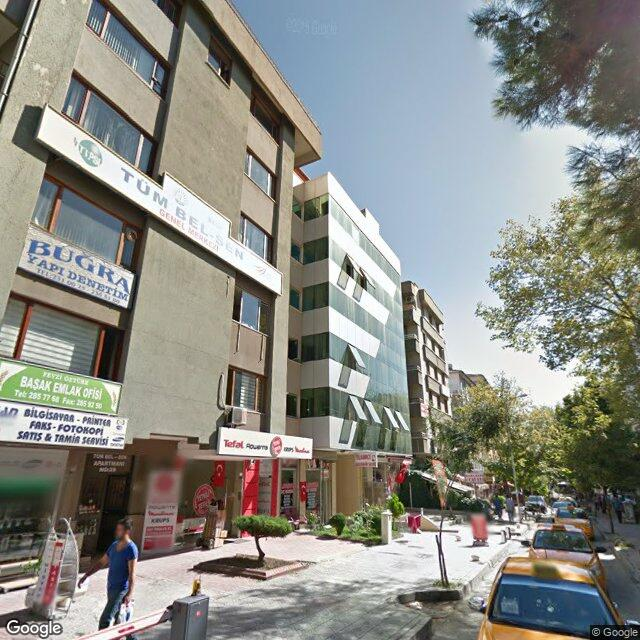

In [ ]:
import random
from PIL import Image

random.seed(42)
image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
print(random_image_path)

image_class = random_image_path.parent.stem
print(image_class)

img= Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

## 3. Transforming data

In [ ]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from torchvision import transforms

data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



In [ ]:
data_transform(img)

tensor([[[0.4337, 0.4508, 0.5536,  ..., 0.1083, 0.0569, 0.1254],
         [0.4166, 0.4679, 0.6049,  ..., 0.1083, 0.0569, 0.0398],
         [0.4508, 0.5193, 0.5022,  ..., 0.1426, 0.0912, 0.0569],
         ...,
         [0.5364, 0.6906, 0.6049,  ..., 1.2043, 1.2557, 1.1872],
         [0.5878, 1.0844, 0.9303,  ..., 1.1529, 1.2728, 1.2385],
         [0.6734, 1.1358, 1.1700,  ..., 1.2385, 1.2043, 1.2728]],

        [[0.2577, 0.2752, 0.3978,  ..., 0.7479, 0.7129, 0.7829],
         [0.2577, 0.2927, 0.4328,  ..., 0.7479, 0.7129, 0.7129],
         [0.2927, 0.3627, 0.3627,  ..., 0.7304, 0.6954, 0.6779],
         ...,
         [0.5028, 0.6429, 0.5903,  ..., 1.4307, 1.4132, 1.3256],
         [0.6078, 1.0980, 0.9580,  ..., 1.3606, 1.4307, 1.3782],
         [0.7479, 1.2206, 1.2031,  ..., 1.4482, 1.3782, 1.4132]],

        [[0.4962, 0.5136, 0.6356,  ..., 0.7402, 0.7054, 0.7576],
         [0.4788, 0.5311, 0.6705,  ..., 0.7576, 0.7054, 0.7054],
         [0.5136, 0.6008, 0.5834,  ..., 0.7402, 0.7054, 0.

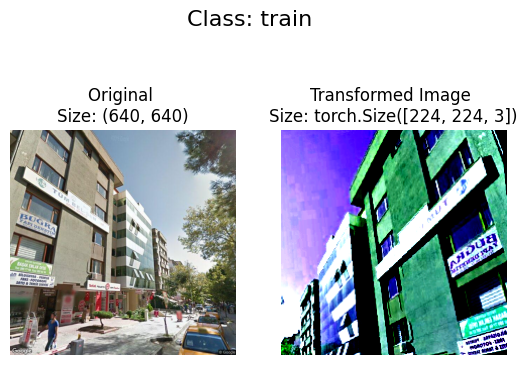

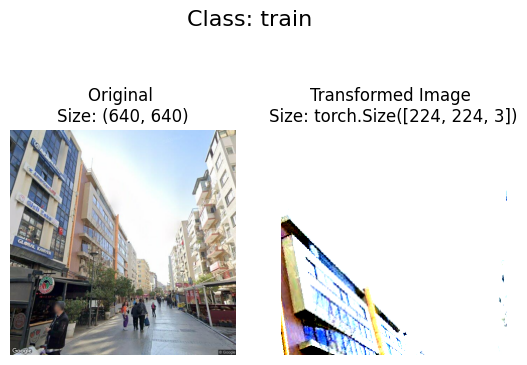

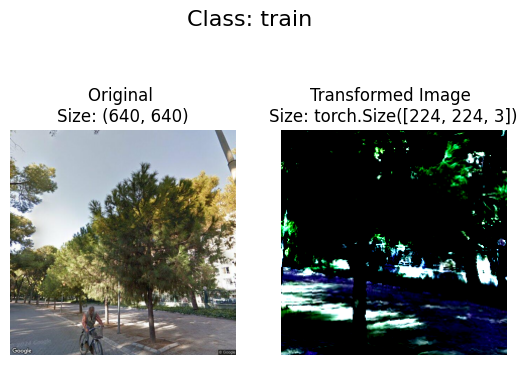

In [ ]:
# Plots a series of random images from image_paths
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)

    for image_path in random_image_paths:
        with Image.open(image_path) as f:
          fig ,ax  = plt.subplots(1,2)
          ax[0].imshow(f)
          ax[0].set_title(f"Original \nSize: {f.size}")
          ax[0].axis("off")

          transformed_image = transform(f).permute(1,2,0)
          ax[1].imshow(transformed_image)
          ax[1].set_title(f"Transformed Image \nSize: {transformed_image.shape}")
          ax[1].axis("off")

          fig.suptitle(f"Class: {image_path.parent.stem}" ,fontsize=16)

plot_transformed_images(image_path_list, transform=data_transform, n=3)

## 4. Loading Image Data Using [`ImageFolder`]

In [ ]:
train_classes = os.listdir(train_dir)
test_classes = os.listdir(test_dir)
train_classes,test_classes

(['image_14483.jpg',
  'image_11724.jpg',
  'image_16740.jpg',
  'image_13263.jpg',
  'image_12865.jpg',
  'image_16128.jpg',
  'image_13079.jpg',
  'image_14068.jpg',
  'image_12547.jpg',
  'image_16771.jpg',
  'image_14375.jpg',
  'image_12329.jpg',
  'image_16279.jpg',
  'image_13148.jpg',
  'image_12020.jpg',
  'image_13892.jpg',
  'image_11671.jpg',
  'image_13877.jpg',
  'image_10235.jpg',
  'image_16112.jpg',
  'image_15278.jpg',
  'image_12664.jpg',
  'image_14602.jpg',
  'image_12634.jpg',
  'image_14164.jpg',
  'image_15211.jpg',
  'image_10895.jpg',
  'image_14082.jpg',
  'image_14844.jpg',
  'image_12513.jpg',
  'image_15434.jpg',
  'image_16729.jpg',
  'image_12656.jpg',
  'image_15115.jpg',
  'image_12129.jpg',
  'image_12564.jpg',
  'image_12172.jpg',
  'image_11466.jpg',
  'image_13418.jpg',
  'image_10641.jpg',
  'image_12327.jpg',
  'image_10306.jpg',
  'image_15844.jpg',
  'image_16940.jpg',
  'image_15264.jpg',
  'image_12605.jpg',
  'image_11311.jpg',
  'image_1360

In [ ]:
train_data = CustomImageDataset(csv_file="/content/datathon/train_data.csv", img_dir=train_dir,transform=data_transform)
test_data = CustomImageDataset(csv_file="/content/datathon/test.csv", img_dir=test_dir,transform=data_transform)

train_data, test_data

(<__main__.CustomImageDataset at 0x78c7a4c7ddb0>,
 <__main__.CustomImageDataset at 0x78c7a4a6bdf0>)

In [ ]:
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size  # Validation %20
lengths = [train_size, val_size]

train_dataset, val_dataset = random_split(train_data, lengths)

In [ ]:
class_names = train_data.classes
class_dict = train_data.class_to_idx
class_names,class_dict

(['Ankara', 'Istanbul', 'Izmir'], {'Ankara': 0, 'Istanbul': 1, 'Izmir': 2})

In [ ]:
class_names = test_data.classes
class_dict = test_data.class_to_idx
class_names,class_dict

([], {})

In [ ]:
 len(test_data) ,len(train_data)

(0, 7000)

In [ ]:
img ,label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[-0.7822, -0.4911,  0.1597,  ..., -0.5767,  0.0227,  0.1597],
         [-0.1486, -0.0801,  0.4508,  ..., -0.3541, -0.0287, -0.0287],
         [-0.0972, -0.1143, -0.0458,  ..., -0.3541, -0.1143, -0.0629],
         ...,
         [ 0.5707,  0.5022,  0.4679,  ..., -0.2856, -0.5938, -0.8507],
         [ 0.5707,  0.5022,  0.4679,  ..., -0.5253, -0.8849, -1.0390],
         [ 0.5707,  0.4679,  0.4679,  ..., -0.6794, -1.0390, -1.0733]],

        [[ 1.1856,  1.4482,  1.9734,  ...,  1.3081,  1.4132,  0.3277],
         [ 1.9209,  1.9384,  2.1660,  ...,  1.6232,  0.9755, -0.1975],
         [ 2.0434,  1.9734,  1.9209,  ...,  1.5707,  0.5903, -0.1800],
         ...,
         [ 0.3803,  0.3803,  0.3978,  ..., -0.6527, -0.9503, -1.0728],
         [ 0.4153,  0.3803,  0.3978,  ..., -0.7752, -1.0903, -1.1429],
         [ 0.4328,  0.3803,  0.4153,  ..., -0.7752, -1.1253, -1.1078]],

        [[ 1.7337,  1.9603,  2.4483,  ...,  1.8905,  2.0648,  1.0539],
         [ 2.5529,  2.4831,  2.

In [ ]:
class_dict = {'Ankara': 0, 'Istanbul': 1, 'Izmir': 2}
class_names = ['Ankara', 'Istanbul', 'Izmir']


Original shape: torch.Size([3, 224, 224]) -> [color_channels, height, width]
Image permute shape: torch.Size([224, 224, 3]) -> [height, width, color_channels]


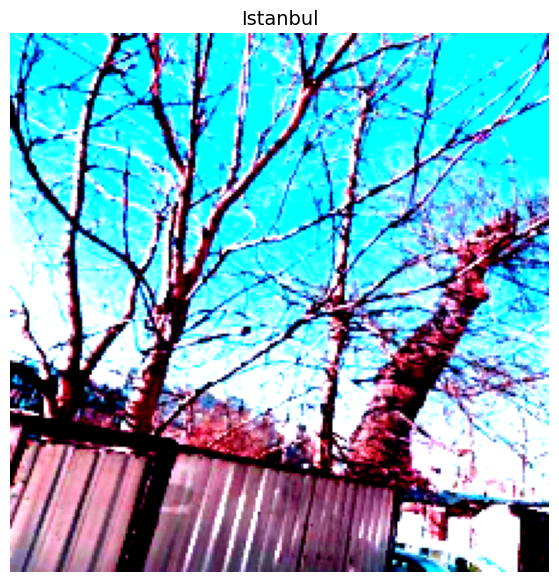

In [ ]:
img_permute = img.permute(1,2,0)

# Print out different shape
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

### 4.1 Turn loaded images into `DataLoader`'s

In [ ]:
batch_size = 32
num_workers = 4

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=num_workers)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False, num_workers=num_workers)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
len(train_dataloader), len(test_dataloader),len(val_dataloader)

(175, 0, 1400)

In [ ]:
# Get image and label from custom dataloader
img_custom ,label_custom = next(iter(train_dataloader))
# Print out the shapes
img_custom.shape ,label_custom.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [ ]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('/content/datathon/train/train/image_14483.jpg'),
 PosixPath('/content/datathon/train/train/image_11724.jpg'),
 PosixPath('/content/datathon/train/train/image_16740.jpg'),
 PosixPath('/content/datathon/train/train/image_13263.jpg'),
 PosixPath('/content/datathon/train/train/image_12865.jpg'),
 PosixPath('/content/datathon/train/train/image_16128.jpg'),
 PosixPath('/content/datathon/train/train/image_13079.jpg'),
 PosixPath('/content/datathon/train/train/image_14068.jpg'),
 PosixPath('/content/datathon/train/train/image_12547.jpg'),
 PosixPath('/content/datathon/train/train/image_16771.jpg')]

## 6. Model:TinyVGG with Data Augmentation


In [ ]:
# class TinyVGG(nn.Module):
#     def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
#         super().__init__()
#         self.conv_block_1 = nn.Sequential(
#             nn.Conv2d(in_channels=input_shape,
#                       out_channels=hidden_units,
#                       kernel_size=3, stride=1, padding=0),
#             nn.ReLU(),
#             nn.Conv2d(in_channels=hidden_units,
#                       out_channels=hidden_units,
#                       kernel_size=3,
#                       stride=1,
#                       padding=0),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))

#         self.conv_block_2 = nn.Sequential(
#             nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
#             nn.ReLU(),
#             nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
#             nn.ReLU(),
#             nn.MaxPool2d(2))

#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             # Where did this in_features shape come from?
#             # It's because each layer of our network compresses and changes the shape of our input data.
#             nn.Linear(in_features=hidden_units*13*13, # because of shape error
#                       out_features=output_shape))

#     def forward(self, x: torch.Tensor):
#         return self.classifier(self.conv_block_2(self.conv_block_1(x)))
#         return x

In [ ]:
from torchvision import datasets, transforms, models
import torch.optim as optim
import torch.nn as nn
torch.manual_seed(42)
# model = TinyVGG(input_shape=3, hidden_units =20, output_shape=len(train_data.classes)).to(device)

model = models.efficientnet_b4(pretrained=True)
num_classes = 3
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(model.classifier[1].in_features, num_classes)
)

model = model.to(device)

# Define optimizer, loss, and scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 89.3MB/s]


In [ ]:
# with torch.no_grad():
#     sample_image = torch.randn(1, 3, 224, 224).to(device)
#     print(model.conv_block_1(sample_image).shape)
#     print(model.conv_block_2(model.conv_block_1(sample_image)).shape)

In [ ]:
# Get a single image batch
img_batch, label_batch = next(iter(train_dataloader))
img_batch.shape, label_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [ ]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 3]                    --
├─Sequential: 1-1                                       [1, 1792, 2, 2]           --
│    └─Conv2dNormActivation: 2-1                        [1, 48, 32, 32]           --
│    │    └─Conv2d: 3-1                                 [1, 48, 32, 32]           1,296
│    │    └─BatchNorm2d: 3-2                            [1, 48, 32, 32]           96
│    │    └─SiLU: 3-3                                   [1, 48, 32, 32]           --
│    └─Sequential: 2-2                                  [1, 24, 32, 32]           --
│    │    └─MBConv: 3-4                                 [1, 24, 32, 32]           2,940
│    │    └─MBConv: 3-5                                 [1, 24, 32, 32]           1,206
│    └─Sequential: 2-3                                  [1, 32, 16, 16]           --
│    │    └─MBConv: 3-6                            

### 6.3 Create train & test loop functions

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)  # Output model logits

        # 2. Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)  # Ensure that train accuracy is averaged per batch

    return train_loss, train_acc
def val_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module):
    # Put model in evaluation mode
    model.eval()

    # Setup validation loss and validation accuracy
    val_loss, val_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            val_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            # 3. Calculate and accumulate accuracy
            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += ((val_pred_labels == y).sum().item()) / len(val_pred_labels)

    # Average loss and accuracy
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)

    return val_loss, val_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss ,test_acc = 0,0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item())/len(test_pred_labels)

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss,test_acc

    correct_predictions, total_predictions = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        predictions = model(X).argmax(dim=1)
        correct_predictions += (predictions == y).sum().item()
        total_predictions += len(y)

    accuracy = correct_predictions / total_predictions

### 6.4 Creating a `train()` function to combine `train_step()` and `test_step()

In [ ]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        val_loss, val_acc = val_step(model=model,
            dataloader=val_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {val_loss:.4f} | "
            f"val_acc: {val_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["val_loss"].append(val_loss.item() if isinstance(val_loss, torch.Tensor) else val_loss)
        results["val_acc"].append(val_acc.item() if isinstance(val_acc, torch.Tensor) else val_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [ ]:
# from collections import Counter
# print(Counter([label for _, label in train_dataloader.dataset]))

Counter({0: 1899, 1: 1865, 2: 1836})


### 6.5 Train and Evaluate Model

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
# model = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
#                   hidden_units=20,
#                   output_shape=len(train_data.classes)).to(device)

model = models.efficientnet_b4(pretrained=True)
num_classes = 3
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(model.classifier[1].in_features, num_classes)
)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3, weight_decay=1e-5)

# Start the timer
from timeit import default_timer as timer
start_time = timer()


# Train model
model_results = train(model=model,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7226 | train_acc: 0.6879 | val_loss: 0.5452 | val_acc: 0.7743
Epoch: 2 | train_loss: 0.5141 | train_acc: 0.7916 | val_loss: 0.4570 | val_acc: 0.8229
Epoch: 3 | train_loss: 0.4294 | train_acc: 0.8279 | val_loss: 0.4067 | val_acc: 0.8464
Epoch: 4 | train_loss: 0.3917 | train_acc: 0.8493 | val_loss: 0.4433 | val_acc: 0.8286
Epoch: 5 | train_loss: 0.3445 | train_acc: 0.8664 | val_loss: 0.3531 | val_acc: 0.8607
Total training time: 1705.726 seconds


In [ ]:
model_results

{'train_loss': [0.7225711911065238,
  0.5141343754529953,
  0.4294102569988796,
  0.3917016617740904,
  0.34448456359761104],
 'train_acc': [0.6878571428571428,
  0.7916071428571428,
  0.8278571428571428,
  0.8492857142857143,
  0.8664285714285714],
 'val_loss': [0.5452092156018714,
  0.4570019355881597,
  0.406712466124836,
  0.443347545371015,
  0.35309058877495814],
 'val_acc': [0.7742857142857142,
  0.8228571428571428,
  0.8464285714285714,
  0.8285714285714286,
  0.8607142857142858]}

In [ ]:
from typing import Tuple, Dict, List
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary."""

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['val_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['val_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

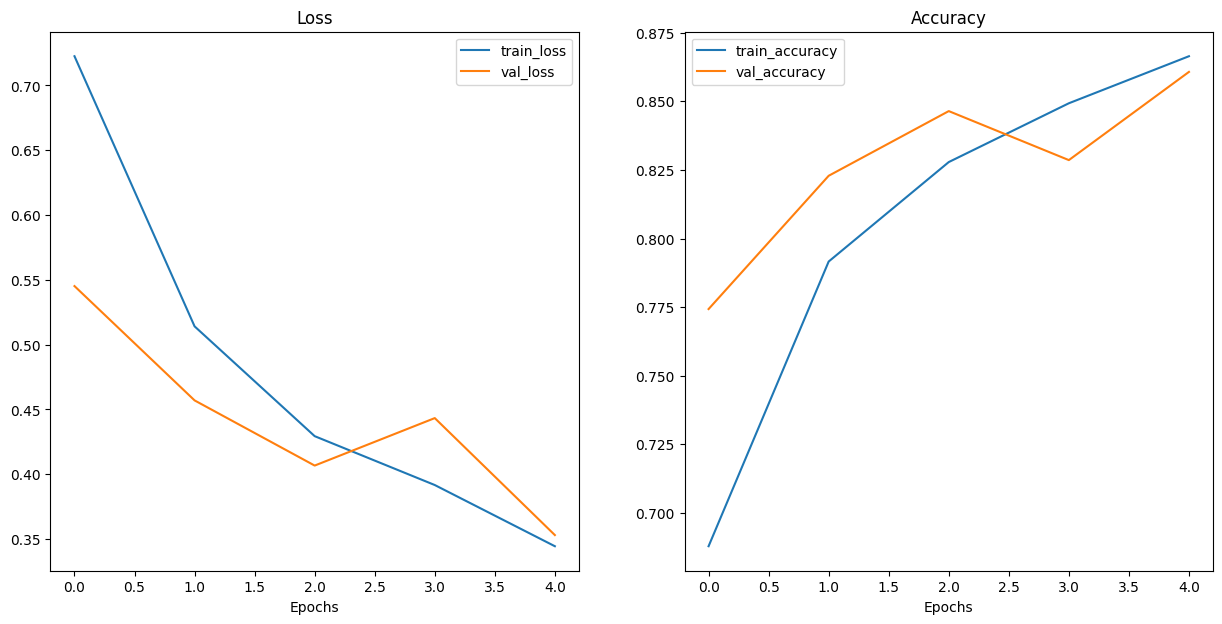

In [ ]:
plot_loss_curves(model_results)

Val Accuracy: 85.64%


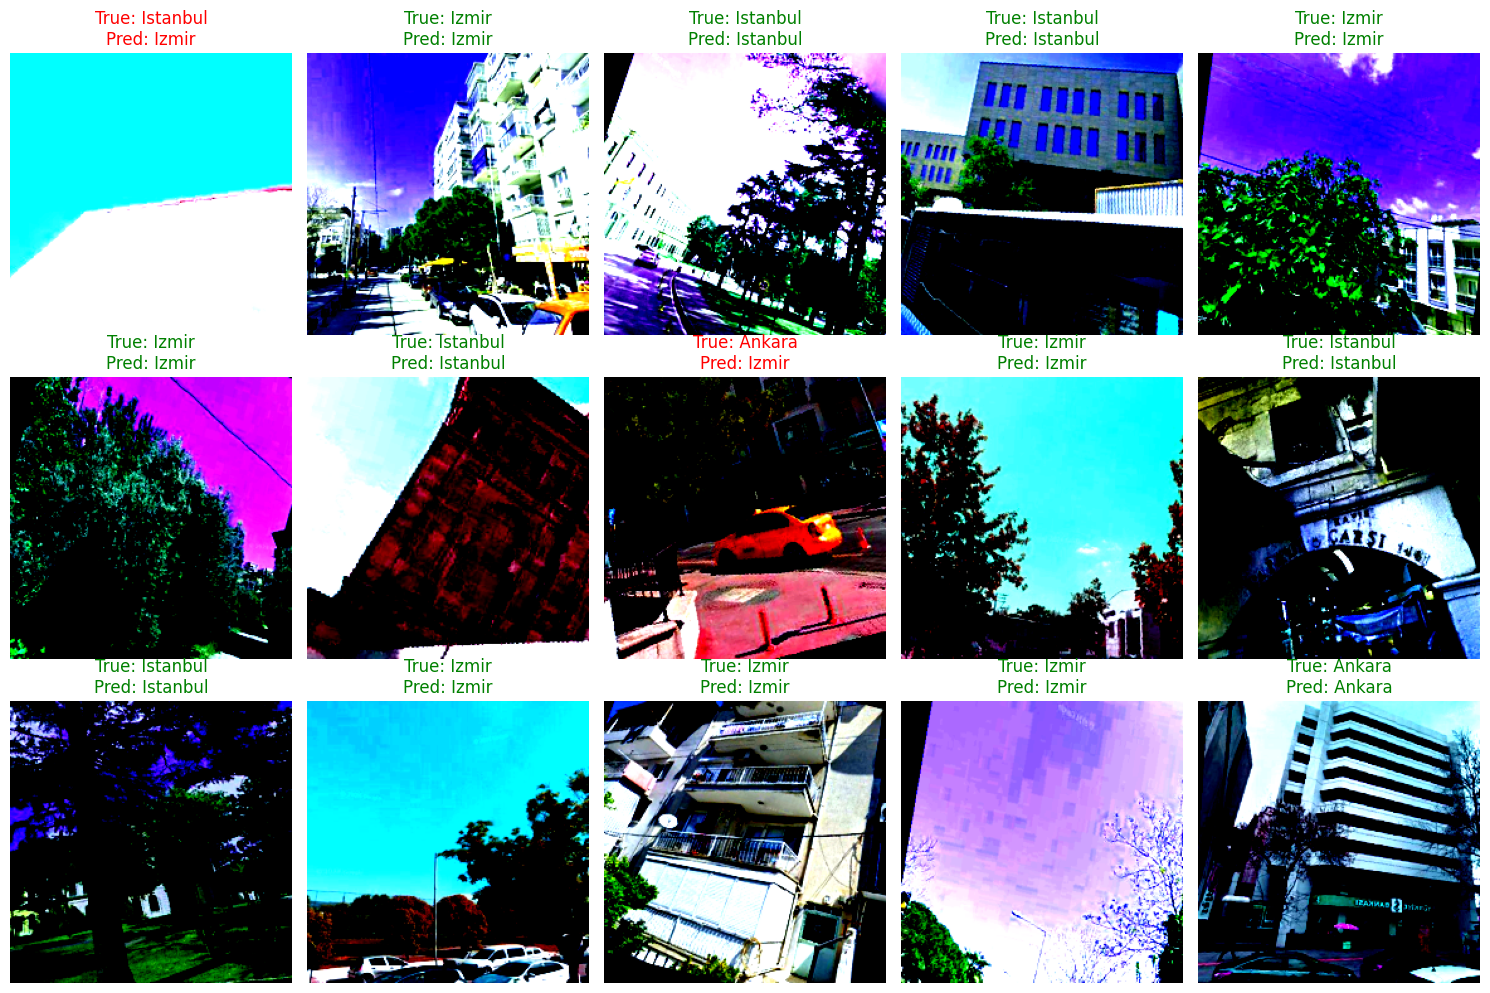

In [ ]:
import matplotlib.pyplot as plt
correct = 0
total = 0
all_images = []
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in val_dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_images.extend(images.cpu())
        all_labels.extend(labels.cpu())
        all_predictions.extend(predicted.cpu())

accuracy = 100 * correct / total
print(f"Val Accuracy: {accuracy:.2f}%")

def plot_predictions(model, dataloader, class_names, device, num_images=15):
    model.eval()

    images_shown = 0
    plt.figure(figsize=(15, 10))

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        with torch.inference_mode():
            preds = model(images).argmax(dim=1)

        for i in range(len(images)):
            if images_shown >= num_images:
                break

            plt.subplot((num_images + 4) // 5, 5, images_shown + 1)
            plt.imshow(images[i].cpu().permute(1, 2, 0))
            plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}",
              color="green" if {class_names[labels[i]]} == {class_names[preds[i]]} else "red")
            plt.axis("off")
            images_shown += 1

        if images_shown >= num_images:
            break

    plt.tight_layout()
    plt.show()
plot_predictions(model, val_dataloader, class_names, device, num_images=15)


## Save and load best performing model


In [ ]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "ai_qual.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/ai_qual.pth


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Load pre-trained EfficientNet model
loaded_model = models.efficientnet_b4(pretrained=True)

# Set the model to evaluation mode
loaded_model.eval()

num_classes = 3
loaded_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(model.classifier[1].in_features, num_classes)
)

# Load the model state dict (assuming the model was saved with the state_dict)
state_dict = torch.load(MODEL_SAVE_PATH)

# Set the device to CUDA if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the state dict into the model
loaded_model.load_state_dict(state_dict)

# Move the model to the appropriate device (GPU or CPU)
loaded_model = loaded_model.to(device)

# Ensure the model is in evaluation mode
loaded_model.eval()



<ipython-input-66-f57f4f4e2f30>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(MODEL_SAVE_PATH)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = (y_true == y_pred).sum().item()
    accuracy = (correct / len(y_true)) * 100
    return accuracy


In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            # Make predictions with the model
            y_pred = model(X)

            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [ ]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_results = eval_model(
    model=loaded_model,
    data_loader=val_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

loaded_model_results

{'model_name': 'EfficientNet',
 'model_loss': 0.34960514307022095,
 'model_acc': 85.78571428571429}

In [ ]:
model = model.to(device)
model_results2 = eval_model(
    model=model,
    data_loader=val_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_results2

{'model_name': 'EfficientNet',
 'model_loss': 1.0409971475601196,
 'model_acc': 58.214285714285715}

In [ ]:
from torch import nn
import torch
from torchvision import transforms
from PIL import Image
import pandas as pd
import os

# Define paths
test_csv_path = "/content/datathon/test.csv"  # Your test.csv file path
test_images_dir = "/content/datathon/test/test"  # Directory containing test images
submission_csv_path = "submission.csv"  # Final submission file

# Load test.csv
test_df = pd.read_csv(test_csv_path)

# Define preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match the model's input
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (example for ImageNet)
])

# Define class-to-city mapping
class_to_city = {
    0: "Ankara",
    1: "Istanbul",
    2: "Izmir"
}

# Prepare for predictions
predictions = []

# Iterate over the test dataset
for _, row in test_df.iterrows():
    filename = row['filename']
    image_path = os.path.join(test_images_dir, filename)

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Make prediction
    with torch.no_grad():
        output = loaded_model(input_tensor)
        pred_class = output.argmax(dim=1).item()  # Get the predicted class index
        predicted_city = class_to_city[pred_class]  # Map the index to the city name

    predictions.append(predicted_city)

# Add predictions to the dataframe
test_df['city'] = predictions

# Save the submission file
test_df[['filename', 'city']].to_csv(submission_csv_path, index=False)

print(f"Submission file saved to {submission_csv_path}")


Submission file saved to submission.csv


In [ ]:
import pandas as pd

submission_csv_path = pd.read_csv('submission.csv')
print(submission_csv_path.head())


          filename      city
0  image_17000.jpg     Izmir
1  image_17001.jpg     Izmir
2  image_17002.jpg  Istanbul
3  image_17003.jpg  Istanbul
4  image_17004.jpg     Izmir
